In [260]:

import pandas as pd
import cv2
import numpy as np



class driveFile:
  def __init__(self):
    self.path=""
  def dataload(self,folder_path):
    img=[]
    label=[]
    import os
    self.path1=os.path.join(self.path,folder_path)
    
    if os.path.exists(self.path1):
      for i in os.listdir(self.path1):
        self.dis_path=os.path.join(self.path1,i)
        # /content/drive/MyDrive/train_set/BA- cellulitis
        if os.path.exists(self.dis_path) and '.DS_Store' not in self.dis_path:
          for j in os.listdir(self.dis_path):
           if j.endswith(('.jpg', '.png', '.jpeg')):
              self.img_path = os.path.join(self.dis_path, j)
              loaded_img= self.imgload(self.img_path)
              if loaded_img is not None:
                img.append(loaded_img)
                label.append(i)
              else:
                 print("Skipping non-image file:", j)
          else:
              print("Skipping invalid path or .DS_Store:", self.dis_path)
              continue
      return np.array(img), np.array(label)
    else:
      return "patherror","patherror"



  def imgload(self,imgpath):
    img=cv2.imread(imgpath)
    if img is None:
      print(f"Failed to load image at {imgpath}")
      return None
    img=cv2.resize(img,(20,20))
    # v imp, usually 224*224 but here 20*20 "downsampling or using a smaller image resolution before flattening it."
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img.astype('float32')/255.0
    img_array=np.array(img)
    return img_array

In [261]:

drive=driveFile()
images,labels=drive.dataload('train_set')

Skipping invalid path or .DS_Store: train_set/FU-athlete-foot
Skipping invalid path or .DS_Store: train_set/BA- cellulitis


In [262]:
class Layer:
    def __init__(self):
        self.input=None
        self.output=None
    def forward(self,input):
        # to be overridden 
        pass 
    def backward(self,output_gradient,learning_rate):
        pass
    

In [263]:
class Dense(Layer):
    def __init__(self,input_size,output_size):
        self.weights=np.random.randn(output_size,input_size)*0.01
        self.bias=np.random.randn(output_size,1)
    def forward(self,input):
        self.input=input
        return np.dot(self.weights,self.input)+self.bias
    def backward(self,output_gradient,learning_rate):
        w_gradient = np.dot(output_gradient, self.input.T)  # (output_size, input_size)
        b_gradient = np.sum(output_gradient, axis=1, keepdims=True)  # (output_size, 1)
        input_gradient = np.dot(self.weights.T, output_gradient)  # (input_size, batch_size)
        self.weights-=learning_rate * w_gradient
        self.bias-=learning_rate * b_gradient
        return input_gradient

In [264]:
class Activation(Layer):
    def __init__(self,activation,activatn_derivative):
        #activation is a variable pointing to a activation method,for ex sigmoid
        self.activation=activation
        self.activatn_derivative=activatn_derivative
    def forward(self,input):
        self.input=input
        return self.activation(self.input)
    def backward(self,output_gradient,learning_rate):
        return np.multiply(output_gradient,self.activatn_derivative(self.input))

In [265]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        def sigmoid_derivative(x):
            s=sigmoid(x)
            return s*(1-s)
        super().__init__(sigmoid,sigmoid_derivative)
        

In [266]:
class Loss(Layer):
    def __init__(self,loss_fn,loss_fn_Derivative):
        self.loss_fn=loss_fn
        self.loss_fn_Derivative=loss_fn_Derivative
    def forward(self,y_pred,y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        return self.loss_fn(y_pred, y_true)
    def backward(self,y_pred,y_true):
        return self.loss_fn_Derivative(y_pred,y_true)

In [267]:
class BinaryCrossEntropy(Loss):
    def __init__(self):
        def bce(y_pred,y_true):
            y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Prevent extreme values
            return -np.mean((y_true*np.log(y_pred))+((1-y_true)*np.log(1-y_pred)))
        def bce_derivative(y_pred,y_true):
            y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Avoid division by zero
            return -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))
        super().__init__(bce,bce_derivative)


In [268]:
class Model:
    def __init__(self, layers, learning_rate=0.01, batch_size=32, epochs=10):
        self.layers = layers
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss_fn = BinaryCrossEntropy()

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, loss_gradient):
        for layer in reversed(self.layers):
            loss_gradient = layer.backward(loss_gradient, self.learning_rate)

    def train(self, X, y):
        for epoch in range(self.epochs):
            num_samples = X.shape[0]
            index=np.arange(num_samples)
            np.random.shuffle(index)
            X=X[index]
            y=y[index]
            for i in range(0, num_samples, self.batch_size):
                if(i+self.batch_size==num_samples):
                    X_batch = X[i:num_samples]
                    y_batch = y[i:num_samples]
                else:
                    X_batch = X[i:i + self.batch_size]
                    y_batch = y[i:i + self.batch_size]

                # Forward pass
                predictions = self.forward(X_batch.T)

                # Compute loss
                loss = self.loss_fn.forward(predictions, y_batch.T)
                print(f"Epoch {epoch + 1}, Batch {i // self.batch_size + 1}, Loss: {loss}")

                # Backward pass
                loss_gradient = self.loss_fn.backward(predictions, y_batch.T)
                self.backward(loss_gradient)

    def predict(self, X):
        predictions = self.forward(X.T)
        return (predictions >= 0.5).astype(int).flatten()

    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        print(f"Accuracy: {accuracy * 100:.2f}%")
        return accuracy



In [269]:
images=np.array([img.flatten() for img in images])
labels=np.array([1 if label=='BA- cellulitis' else 0 for label in labels])
input_size = images.shape[1]
layers = [Dense(input_size, 1), Sigmoid()]
model = Model(layers, learning_rate=0.01, batch_size=8, epochs=15)
model.train(images, labels)

Epoch 1, Batch 1, Loss: 0.6858312070151591
Epoch 1, Batch 2, Loss: 0.7919152053159743
Epoch 1, Batch 3, Loss: 0.9277544386079506
Epoch 1, Batch 4, Loss: 0.2432375542185935
Epoch 1, Batch 5, Loss: 1.5050042987121282
Epoch 1, Batch 6, Loss: 0.5438262854095194
Epoch 1, Batch 7, Loss: 0.4827561481216765
Epoch 1, Batch 8, Loss: 1.3585443013287963
Epoch 1, Batch 9, Loss: 2.162336012254296
Epoch 1, Batch 10, Loss: 1.8373498595251125
Epoch 1, Batch 11, Loss: 3.0453029910646476
Epoch 1, Batch 12, Loss: 1.0098189843480512
Epoch 1, Batch 13, Loss: 1.2796390152460293
Epoch 1, Batch 14, Loss: 0.6317174986053002
Epoch 1, Batch 15, Loss: 1.0717824334778279
Epoch 1, Batch 16, Loss: 1.3992290278248474
Epoch 1, Batch 17, Loss: 0.6742949446097518
Epoch 1, Batch 18, Loss: 0.5874134938173561
Epoch 1, Batch 19, Loss: 0.9887244216353023
Epoch 1, Batch 20, Loss: 0.8150771748634282
Epoch 1, Batch 21, Loss: 0.789962516935327
Epoch 1, Batch 22, Loss: 0.6744753226978046
Epoch 1, Batch 23, Loss: 0.8145809120001659

In [270]:
test_images, test_labels = drive.dataload('test_set')
test_images = np.array([img.flatten() for img in test_images])
test_labels = np.array([1 if label == 'BA- cellulitis' else 0 for label in test_labels])
model.evaluate(test_images, test_labels)

Skipping invalid path or .DS_Store: test_set/FU-athlete-foot
Skipping invalid path or .DS_Store: test_set/BA- cellulitis
Accuracy: 69.23%


np.float64(0.6923076923076923)

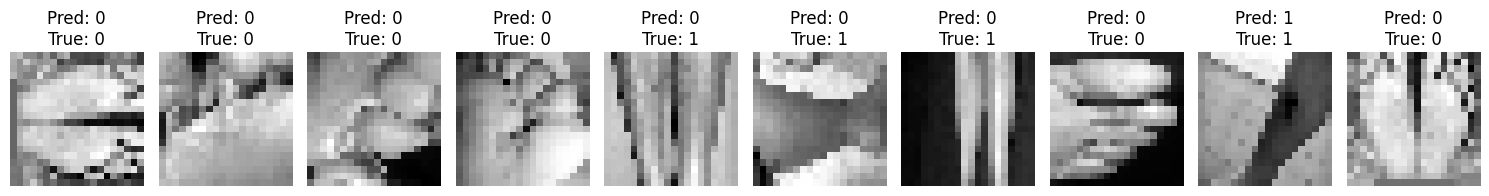

In [271]:
import matplotlib.pyplot as plt

def visualize_predictions(model, images, labels, num_images=10):
    # Get predictions
    predictions = model.predict(images[:num_images])
    predicted_labels = (predictions >= 0.5).astype(int).flatten()  # Threshold for binary classification
    
    # Plot images with predictions and true labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(20, 20), cmap='gray')  # Reshape to original image size
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {predicted_labels[i]}\nTrue: {labels[i]}")
    
    plt.tight_layout()
    plt.show()
index=np.arange(test_images.shape[0])
np.random.shuffle(index)
test_images=test_images[index]
test_labels=test_labels[index]
subset_images = test_images[:10]
subset_labels = test_labels[:10]

# Visualize predictions
visualize_predictions(model, subset_images, subset_labels)

In [272]:
import pickle

# Save the model parameters
def save_model(model, filename='model.pkl'):
    model_params = {
        'layers': [(layer.weights, layer.bias) for layer in model.layers if isinstance(layer, Dense)],
        'input_size': model.layers[0].weights.shape[1]
    }
    with open(filename, 'wb') as f:
        pickle.dump(model_params, f)

# Save trained model
save_model(model, 'skin_disease_model.pkl')


In [273]:
# Load the model parameters
def load_model(filename='model.pkl'):
    with open(filename, 'rb') as f:
        model_params = pickle.load(f)

    layers = []
    for weights, bias in model_params['layers']:
        dense_layer = Dense(weights.shape[1], weights.shape[0])
        dense_layer.weights = weights
        dense_layer.bias = bias
        layers.append(dense_layer)
        layers.append(Sigmoid())

    return Model(layers, learning_rate=0.1, batch_size=8, epochs=10)

# Load the trained model
loaded_model = load_model('skin_disease_model.pkl')


In [274]:
import gradio as gr
import numpy as np
import cv2

# Prediction function
def predict(image):
    # Preprocess the image
    image = cv2.resize(image, (20, 20))  # Resize to 20x20
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = image.astype('float32') / 255.0  # Normalize
    flattened_image = image.flatten().reshape(-1, 1)  # Flatten and reshape

    # Make a prediction
    pred = loaded_model.predict(flattened_image.T)
    return f"Disease Detected: {'BA-cellulitis' if pred[0] == 1 else 'Foot ulcer'}"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=gr.Label(label="Prediction"),
    title="Skin Disease Classifier",
    description="Upload an image of the skin, and the model will predict whether it's BA-cellulitis or Foot ulcer."
)

# Launch the web app
interface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
